In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Load the dataset
df = pd.read_csv("10k_diabetes (1).csv")


# Data preprocessing
# Replace '?' with 'Unknown' for categorical variables
df['weight'] = df['weight'].replace('?', 'Unknown')
df['medical_specialty'] = df['medical_specialty'].replace('?', 'Unknown')
df['payer_code'] = df['payer_code'].replace("?", 'Unknown')

# Fill missing admission types with mode
df['admission_type_id'] = df['admission_type_id'].fillna(df['admission_type_id'].mode()[0])
df['admission_source_id'] = df['admission_source_id'].fillna(df['admission_source_id'].mode()[0])


In [6]:
# Convert age ranges to numeric midpoints
def age_to_midpoint(age_range):
    if pd.isna(age_range) or age_range == '?':
        return None
    nums = [int(x) for x in age_range.strip('[]()').split('-')]
    return sum(nums) / 2

df['age_numeric'] = df['age'].apply(age_to_midpoint)

# Create binary readmission target
df['readmitted_30'] = df['readmitted'].astype(int)

# Categorize diagnosis
def categorize_diagnosis(diag_desc):
    if pd.isna(diag_desc):
        return 'Unknown'
    diag_lower = str(diag_desc).lower()
    if 'diabetes' in diag_lower:
        return 'Diabetes'
    elif any(x in diag_lower for x in ['heart', 'cardiac', 'coronary']):
        return 'Cardiovascular'
    elif any(x in diag_lower for x in ['respiratory', 'pneumonia', 'copd']):
        return 'Respiratory'
    else:
        return 'Other'

# Categorize and create dummy variables
df['primary_diagnosis_category'] = df['diag_1_desc'].apply(categorize_diagnosis)
diagnosis_dummies = pd.get_dummies(df['primary_diagnosis_category'], prefix='diag_cat')
df = pd.concat([df, diagnosis_dummies], axis=1)

# Create health score
numerical_cols = ['num_lab_procedures', 'num_procedures', 'num_medications']
scaler = StandardScaler()
normalized_vals = scaler.fit_transform(df[numerical_cols])
df['health_score'] = (normalized_vals[:, 0] * 0.3 + 
                     normalized_vals[:, 1] * 0.3 + 
                     normalized_vals[:, 2] * 0.4)

# Feature encodings
nominal_features = ['race', 'gender', 'medical_specialty']
for feature in nominal_features:
    dummies = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(feature, axis=1)

ordinal_features = ['discharge_disposition_id', 'admission_source_id']
le = LabelEncoder()
for feature in ordinal_features:
    df[f'{feature}_encoded'] = le.fit_transform(df[feature].astype(str))

# Create interaction features
df['procedure_medication_interaction'] = df['num_procedures'] * df['num_medications']
df['lab_medication_interaction'] = df['num_lab_procedures'] * df['num_medications']

# Create complexity scores
df['medical_complexity'] = (
    df['num_lab_procedures'] * 0.4 +
    df['num_procedures'] * 0.3 +
    df['num_medications'] * 0.3 +
    (df['diag_cat_Diabetes'].fillna(0) * 0.2) +
    (df['diag_cat_Cardiovascular'].fillna(0) * 0.2)
)

df['diagnosis_severity'] = (
    (df['diag_cat_Diabetes'].fillna(0) * 3) +
    (df['diag_cat_Cardiovascular'].fillna(0) * 2) +
    (df['diag_cat_Respiratory'].fillna(0) * 2) +
    (df['diag_cat_Other'].fillna(0) * 1)
)

# Prepare features for modeling
def prepare_modeling_features(df):
    """Prepare feature sets for modeling tasks"""
    
    common_features = [
        'age_numeric', 'time_in_hospital', 'num_lab_procedures',
        'num_procedures', 'num_medications', 'health_score',
        'medical_complexity', 'diagnosis_severity',
        'procedure_medication_interaction', 'lab_medication_interaction',
        'discharge_disposition_id_encoded', 'admission_source_id_encoded'
    ]
    
    # Get all dummy columns
    dummy_cols = [col for col in df.columns if any(x in col for x in 
                 ['diag_cat_', 'race_', 'gender_', 'medical_specialty_'])]
    
    # Combine features
    feature_cols = common_features + dummy_cols
    
    # Select only existing columns
    existing_cols = [col for col in feature_cols if col in df.columns]
    
    return existing_cols

In [7]:
# Prepare features and target
selected_features = prepare_modeling_features(df)
X = df[selected_features]
y_readmission = df['readmitted_30']

# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_readmission, test_size=0.2, random_state=42, stratify=y_readmission
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Create TensorFlow model
tf.random.set_seed(42)
model = models.Sequential([
    layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', tf.keras.metrics.AUC()])

# Add early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [9]:
# Train model
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5414 - auc: 0.5148 - loss: 0.6858 - val_accuracy: 0.6112 - val_auc: 0.5976 - val_loss: 0.6625
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.6095 - auc: 0.5891 - loss: 0.6588 - val_accuracy: 0.6169 - val_auc: 0.6122 - val_loss: 0.6593
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.6155 - auc: 0.6076 - loss: 0.6527 - val_accuracy: 0.6169 - val_auc: 0.6153 - val_loss: 0.6575
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.6171 - auc: 0.6177 - loss: 0.6488 - val_accuracy: 0.6187 - val_auc: 0.6168 - val_loss: 0.6545
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6228 - auc: 0.6264 - loss: 0.6461 - val_accuracy: 0.6144 - val_auc: 0.6216 - val_loss: 0.6534
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.6227 - auc: 0.6342 - loss: 0.6427 - val_accuracy: 0.6125 - val_auc: 0.6238 - val_loss: 0.6529
Epoch 7/100
200/200 ━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      1207
           1       0.51      0.43      0.47       793

    accuracy                           0.61      2000
   macro avg       0.59      0.58      0.58      2000
weighted avg       0.60      0.61      0.60      2000


ROC-AUC Score: 0.6164


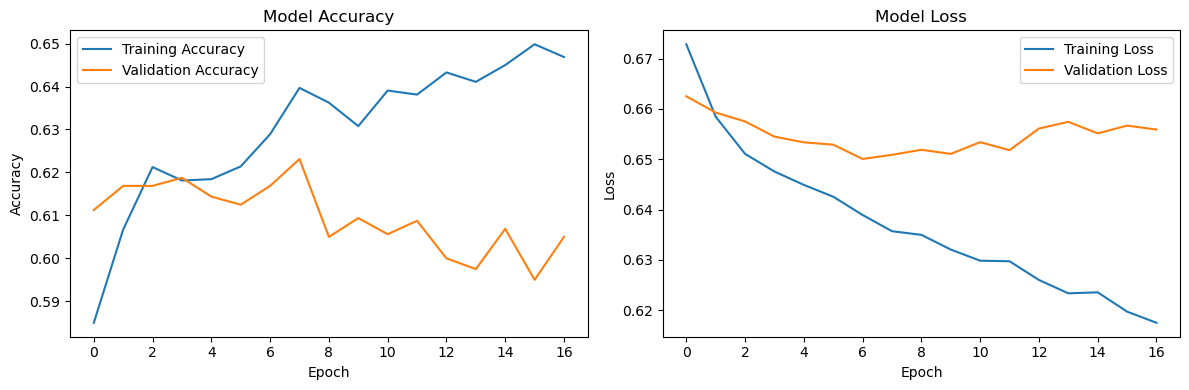

In [10]:
# Evaluate model
y_pred_proba = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Print results
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()